<a href="https://colab.research.google.com/github/thisissepehr/image-classification-deep-models/blob/main/resNet_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import torch
print(torch.__version__)
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
import time
import numpy as np
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor

import torch.nn.functional as F
import cv2
import torchvision
from torchvision import datasets
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
from sklearn.metrics import classification_report, confusion_matrix
from torchsummary import summary

1.11.0+cu113


In [8]:
# Hyperparameters
RANDOM_SEED = 42
LEARNING_RATE = 1e-3
BATCH_SIZE = 64
NUM_EPOCHS = 10

# Architecture
NUM_FEATURES = 28*28
NUM_CLASSES = 10

# Other
DEVICE = "cuda:0"
GRAYSCALE = False

torch.manual_seed(RANDOM_SEED)

In [9]:
transform_train = transforms.Compose([
    transforms.ToTensor(),
    ])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    ])


train_ds = datasets.CIFAR10(root='data', 
                               train=True, 
                               transform=transform_train,
                               download=True)
train_set, val_set = torch.utils.data.random_split(train_ds, [45000, 5000])

test_ds = datasets.CIFAR10(root='data', 
                              train=False, 
                              transform=transform_test)


train_loader = DataLoader(dataset=train_set,
                          batch_size=BATCH_SIZE,
                      shuffle = True)


val_loader = DataLoader(dataset=val_set,
                          batch_size=BATCH_SIZE,
                      shuffle = False)

test_loader = DataLoader(dataset=test_ds,
                     batch_size=BATCH_SIZE,
                     shuffle = False)

# Checking the dataset
images, labels = next(iter(train_loader))  
print('Image batch dimensions:', images.shape)
print('Image label dimensions:', labels.shape)

Files already downloaded and verified
Image batch dimensions: torch.Size([64, 3, 32, 32])
Image label dimensions: torch.Size([64])


images.shape: torch.Size([64, 3, 32, 32])


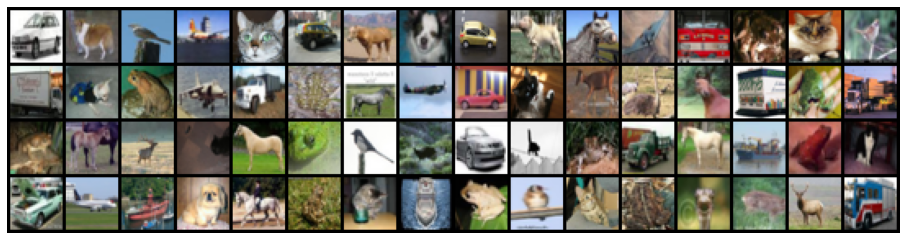

In [10]:
images, _ = next(iter(train_loader))
print('images.shape:', images.shape)
plt.figure(figsize=(16,8))
plt.axis('off')
plt.imshow(torchvision.utils.make_grid(images, nrow=16).permute((1, 2, 0)))

In [34]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        # probas = F.softmax(out, dim=1)
        return out




In [35]:
def accuracy(model, data_loader, device):
    with torch.no_grad():
        correct_predictions, counter = 0, 0
        for _, (img, label) in enumerate(data_loader):
            img = img.to(device)
            label = label.float().to(device)
            logits = model(img)
            _, predicted_label = torch.max(logits, 1)
            counter += label.size(0)
            correct_predictions += (predicted_label == label).sum()
    return correct_predictions.float()/counter * 100

In [36]:
def init_weights(m):
    if isinstance(m, torch.torch.nn.Conv2d) or isinstance(m, torch.torch.nn.Linear):
        torch.nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')
        if m.bias is not None:
            m.bias.detach().zero_()

In [37]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = ResNet(BasicBlock, [2, 2, 2, 2])
model.apply(init_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
model = model.to(DEVICE)

In [38]:
def train(model, num_epochs, train_loader,valid_loader, test_loader, optimizer):
    start_time = time.time()
    for epoch in range(num_epochs):
        model.train()
        for batch_idx, (features, targets) in tqdm(enumerate(train_loader), total= len(train_loader)):
            features = features.to(DEVICE)
            targets = targets.to(DEVICE)
            logits = model(features)
            loss = torch.nn.functional.cross_entropy(logits, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        model.eval()
        with torch.no_grad():
            train_acc = accuracy(model, train_loader, device=DEVICE)
            valid_acc = accuracy(model, valid_loader, device=DEVICE)
            print(f'Epoch: {epoch+1:03d}/{num_epochs:03d} '
                  f'| Train: {train_acc :.2f}% '
                  f'| Validation: {valid_acc :.2f}%')
        elapsed = (time.time() - start_time)/60
        print(f'Time elapsed: {elapsed:.2f} min')        
    elapsed = (time.time() - start_time)/60
    print(f'Total Training Time: {elapsed:.2f} min')
    test_acc = accuracy(model, test_loader, device=DEVICE)
    print(f'Test accuracy {test_acc :.2f}%')

In [39]:
train(model= model,
      num_epochs = NUM_EPOCHS,
      train_loader= train_loader,
      valid_loader = val_loader,
      test_loader = test_loader,
      optimizer = optimizer)

  0%|          | 0/704 [00:00<?, ?it/s]

Epoch: 001/010 | Train: 67.75% | Validation: 65.60%
Time elapsed: 0.77 min


  0%|          | 0/704 [00:00<?, ?it/s]

Epoch: 002/010 | Train: 77.74% | Validation: 73.76%
Time elapsed: 1.53 min


  0%|          | 0/704 [00:00<?, ?it/s]

Epoch: 003/010 | Train: 84.67% | Validation: 79.26%
Time elapsed: 2.30 min


  0%|          | 0/704 [00:00<?, ?it/s]

Epoch: 004/010 | Train: 86.66% | Validation: 79.14%
Time elapsed: 3.07 min


  0%|          | 0/704 [00:00<?, ?it/s]

Epoch: 005/010 | Train: 92.60% | Validation: 81.84%
Time elapsed: 3.84 min


  0%|          | 0/704 [00:00<?, ?it/s]

Epoch: 006/010 | Train: 95.41% | Validation: 82.80%
Time elapsed: 4.61 min


  0%|          | 0/704 [00:00<?, ?it/s]

Epoch: 007/010 | Train: 95.20% | Validation: 81.50%
Time elapsed: 5.37 min


  0%|          | 0/704 [00:00<?, ?it/s]

Epoch: 008/010 | Train: 96.26% | Validation: 81.80%
Time elapsed: 6.14 min


  0%|          | 0/704 [00:00<?, ?it/s]

Epoch: 009/010 | Train: 97.19% | Validation: 82.20%
Time elapsed: 6.91 min


  0%|          | 0/704 [00:00<?, ?it/s]

Epoch: 010/010 | Train: 97.49% | Validation: 81.82%
Time elapsed: 7.68 min
Total Training Time: 7.68 min
Test accuracy 81.80%


In [40]:
def get_prediction(x, model):
    model.to('cpu') # prepares model for predicting
    probabilities = torch.softmax(model(x), dim=1)
    predicted_class = torch.argmax(probabilities, dim=1)
    return predicted_class, probabilities

In [41]:
true_y, pred_y = [], []
for batch in tqdm(iter(test_loader), total=len(test_loader)):
    x, y = batch
    true_y.extend(y)
    #print(type(x))
    preds, probs = get_prediction(x, model)
    pred_y.extend(preds.cpu())

  0%|          | 0/157 [00:00<?, ?it/s]

In [42]:
print(classification_report(true_y, pred_y, digits=3))


              precision    recall  f1-score   support

           0      0.828     0.827     0.827      1000
           1      0.880     0.935     0.906      1000
           2      0.688     0.777     0.730      1000
           3      0.794     0.509     0.620      1000
           4      0.825     0.811     0.818      1000
           5      0.764     0.759     0.761      1000
           6      0.778     0.923     0.844      1000
           7      0.894     0.849     0.871      1000
           8      0.918     0.865     0.891      1000
           9      0.832     0.925     0.876      1000

    accuracy                          0.818     10000
   macro avg      0.820     0.818     0.814     10000
weighted avg      0.820     0.818     0.814     10000



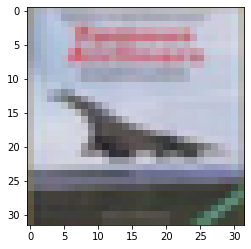

In [43]:
features, targets = next(iter(test_loader))    
nhwc_img = np.transpose(features[3], axes=(1, 2, 0))
# nhw_img = np.squeeze(nhwc_img.numpy(), axis=2)
plt.imshow(nhwc_img, cmap='Greys')


In [44]:
predicted, probability = get_prediction(features[3, None], model)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
print('Predicted: {}'.format(classes[predicted[0]]), predicted)
print('Probability:', probability[0][predicted]*100)

Predicted: plane tensor([0])
Probability: tensor([99.9700], grad_fn=<MulBackward0>)


In [45]:
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.YlGnBu):
    fig, ax = plt.subplots(figsize=(16,16))
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[827  20  51   8   7   1   8   4  28  46]
 [  5 935   3   0   0   2   6   0   5  44]
 [ 46   4 777  17  34  28  67  10   6  11]
 [ 18  12  93 509  51 143 104  27  16  27]
 [ 15   3  65  20 811  24  33  20   6   3]
 [  6   9  69  59  28 759  27  33   3   7]
 [  5   2  24   7  14  12 923   3   5   5]
 [ 16   6  33  13  34  24   8 849   5  12]
 [ 53  25   8   5   3   1   6   2 865  32]
 [  8  47   6   3   1   0   5   2   3 925]]


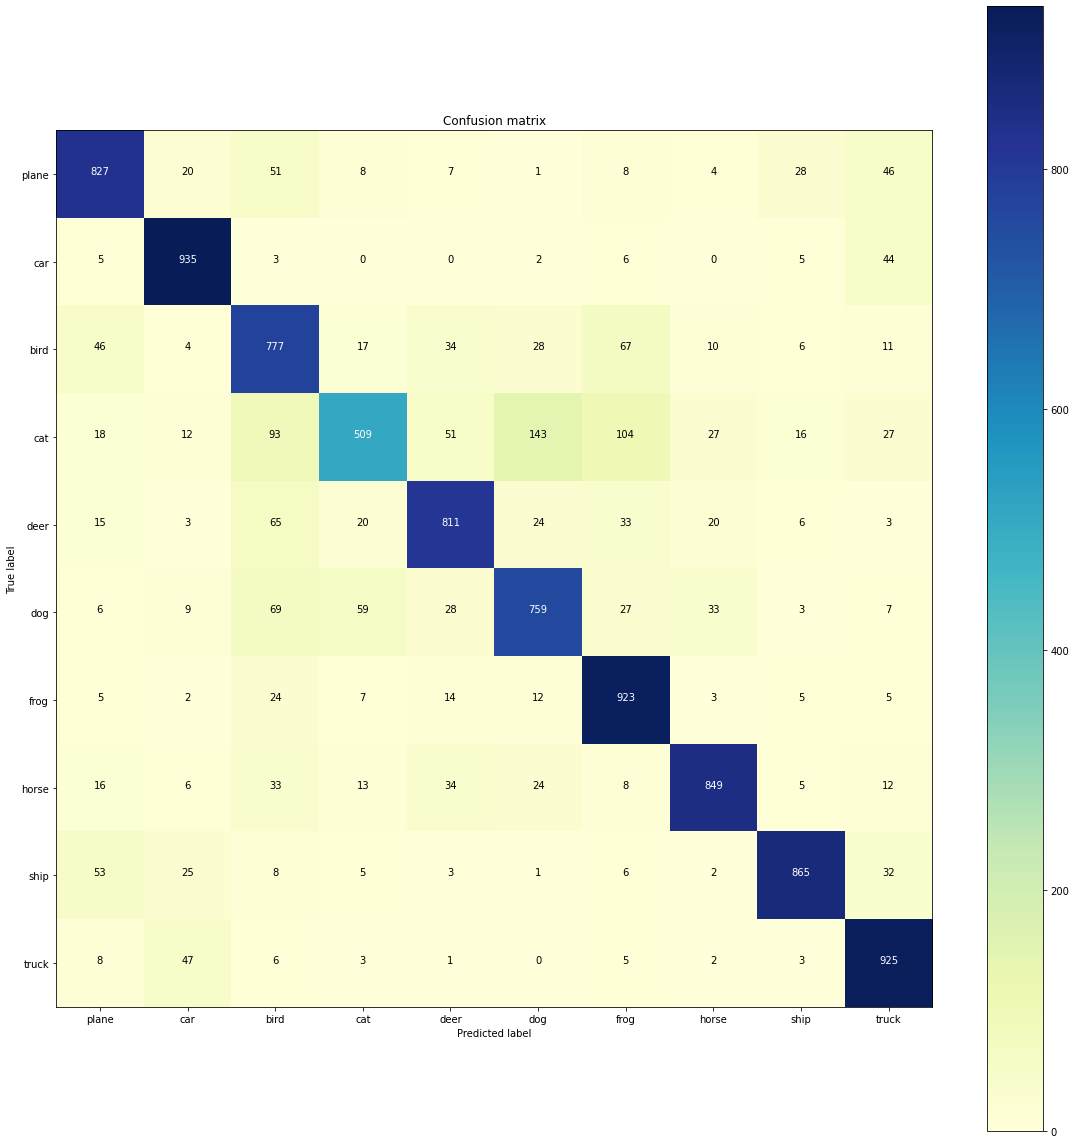

In [48]:
cm = confusion_matrix(true_y, pred_y)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
plot_confusion_matrix(cm,classes)